In [53]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Printing the Directory Path of the Datasets

In [54]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


## Unzipping the Training and Testing Dataset

In [55]:
import zipfile

with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")
file_names_train = os.listdir("./train")

with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as z:
    z.extractall(".")
file_names_test = os.listdir("./test1")

## Prepaing Training and Testing DataFrames

In [56]:
labels = []
for file in file_names_train:
    if file.split('.')[0] == 'cat':
        labels.append('cat')
    else:
        labels.append('dog')
        
df_train = pd.DataFrame({
    'filename':file_names_train,
    'label':labels
})

df_test = pd.DataFrame({
    'filename':file_names_test
})

## Defining Image Characterictics

In [57]:
img_width = 150
img_height = 150
img_channel = 3

## Splitting Training Data into 2 parts: Training and Validation

In [58]:
from sklearn.model_selection import train_test_split

training_df, validate_df = train_test_split(df_train, 
                                            test_size=0.2,
                                            random_state=2)

training_df = training_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

training_size = training_df.shape[0]
validate_size = validate_df.shape[0]
training_size, validate_size

(20000, 5000)

## Exploring Dataset

In [59]:
print('Training Data','\n',training_df['label'].value_counts())
print('Validation Data','\n',training_df['label'].value_counts())

Training Data 
 dog    10017
cat     9983
Name: label, dtype: int64
Validation Data 
 dog    10017
cat     9983
Name: label, dtype: int64


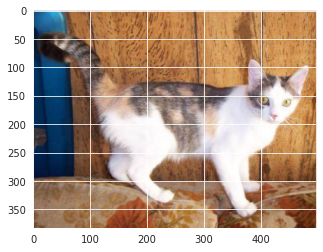

In [60]:
plt.imshow(plt.imread(("./train/"+file_names_train[567])))

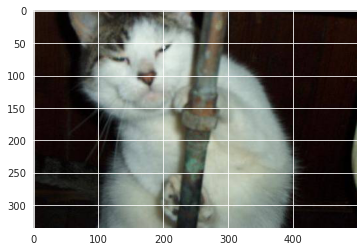

In [61]:
plt.imshow(plt.imread(("./test1/"+file_names_test[876])))

## Loading Images

In [63]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 20
image_size = (img_width, img_height)

'''
datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                validation_split=0.25,
                                horizontal_flip=False,
                                vertical_flip=False)
'''

datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(dataframe=training_df,
                                                   directory='./train',
                                                   x_col='filename',
                                                   y_col='label',
                                                   subset='training',
                                                   batch_size=batch_size,
                                                   target_size=image_size,         
                                                   class_mode='binary')

validation_generator = datagen.flow_from_dataframe(dataframe=validate_df,
                                                   directory='./train',
                                                   x_col='filename',
                                                   y_col='label',
                                                   batch_size=batch_size,
                                                   target_size=image_size,
                                                   class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(df_test,
                                                 directory="./test1",
                                                 x_col="filename",
                                                 y_col=None,
                                                 class_mode  = None,
                                                 target_size=image_size,
                                                 batch_size=batch_size)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


## Defining Model

In [64]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense

model = Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_width,img_height,img_channel)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid')) #This should be 1 as it is a Binary Classification Problem

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

## Defining Callbacks

In [65]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

earlystop = EarlyStopping(monitor='val_acc', 
                          patience=10, 
                          verbose=1)

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',
                                            patience = 5,
                                            verbose = 1,
                                            factor = 0.5,
                                            min_lr = 0.00001)

callbacks = [earlystop,learning_rate_reduction]

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)      

## Training the Model

In [67]:
history=model.fit(train_generator, 
                  validation_data=validation_generator, 
                  epochs=10,
                  callbacks=callbacks)

Epoch 1/10
1000/1000 [==============================] - 81s 80ms/step - loss: 0.8648 - accuracy: 0.5241 - val_loss: 0.6458 - val_accuracy: 0.6240
Epoch 2/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.6318 - accuracy: 0.6455 - val_loss: 0.5491 - val_accuracy: 0.7186
Epoch 3/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.5268 - accuracy: 0.7341 - val_loss: 0.4872 - val_accuracy: 0.7666
Epoch 4/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.4355 - accuracy: 0.7927 - val_loss: 0.4340 - val_accuracy: 0.7990
Epoch 5/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.3538 - accuracy: 0.8379 - val_loss: 0.4236 - val_accuracy: 0.8110
Epoch 6/10
1000/1000 [==============================] - 79s 79ms/step - loss: 0.2666 - accuracy: 0.8865 - val_loss: 0.4658 - val_accuracy: 0.8112
Epoch 7/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.1921 - accuracy: 0.9235 - val_loss: 0.4840 -

## Predicting using the Trained Model

In [68]:
predictions = model.predict(test_generator,steps = np.ceil(df_test.shape[0]/batch_size))
predictions[0:10]

array([[9.9984884e-01],
       [9.9334735e-01],
       [2.6808223e-03],
       [2.0235707e-13],
       [7.8117967e-01],
       [8.1526160e-01],
       [2.2784383e-03],
       [1.8752855e-12],
       [6.9287403e-06],
       [9.5869279e-01]], dtype=float32)

## Preparing the output in the required format

In [70]:
df_test["label"]=pd.DataFrame(predictions, columns=["label"])
df_test.head(5)

,filename,label
0,9241.jpg,9.998488e-01
1,1973.jpg,9.933473e-01
2,12393.jpg,2.680822e-03
3,1521.jpg,2.023571e-13
4,5441.jpg,7.811797e-01


In [71]:
def get_label(x):
    if x > 0.5:
        return 1
    else:
        return 0

In [72]:
df_test['label'] = df_test['label'].apply(get_label)
df_test.head(5)

,filename,label
0,9241.jpg,1
1,1973.jpg,1
2,12393.jpg,0
3,1521.jpg,0
4,5441.jpg,1


In [73]:
df_test=df_test.reset_index()
df_test.head(5)

,index,filename,label
0,0,9241.jpg,1
1,1,1973.jpg,1
2,2,12393.jpg,0
3,3,1521.jpg,0
4,4,5441.jpg,1


In [74]:
df_test=df_test.rename(columns={"index": "id",
                               "label":"category"})
df_test.tail(10)

,id,filename,category
12490,12490,3635.jpg,0
12491,12491,4560.jpg,0
12492,12492,8330.jpg,1
12493,12493,2651.jpg,1
12494,12494,10052.jpg,0
12495,12495,9130.jpg,0
12496,12496,7026.jpg,0
12497,12497,11012.jpg,0
12498,12498,3269.jpg,1
12499,12499,7811.jpg,1


In [75]:
final = df_test.drop("filename", axis=1)

In [77]:
final.to_csv('submission.csv', index=False)